In [1]:

# Environment Setup and Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.ndimage import gaussian_filter
import cv2
import h5py
import os
import datetime
import time
from math import pi

# Configure TensorFlow for better memory management
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"GPUs available: {len(gpus)}")
for gpu in gpus:
    print(f"  {gpu}")


2025-08-13 11:24:37.634258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 11:24:37.643370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755077077.652779   30323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755077077.655436   30323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755077077.662971   30323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
NumPy version: 2.1.3
GPUs available: 1
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:

# Project paths and hyperparameters
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "stage1"))
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
LOGS_DIR = os.path.join(BASE_DIR, "logs")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Image and dataset sizes
IMG_SIZE = 64
N_CHANNELS = 2
N_CLASSES = 4  # 0=square,1=rect,2=tri,3=oblique

# Dataset size (adjust as needed)
N_TRAIN = 20000
N_VAL   = 2000

# Rendering and augmentation
BLUR_SIGMA = 0.5
NOISE_STD  = 0.02

# Regression head order: [a_hat, b_hat, r_hat, sin_gamma, cos_gamma, sin_theta, cos_theta, x0_hat, y0_hat]
PARAM_DIM = 9

# Ranges (normalized by IMG_SIZE for lengths)
A_MIN, A_MAX = 6/IMG_SIZE, 18/IMG_SIZE
B_MIN, B_MAX = 6/IMG_SIZE, 18/IMG_SIZE
R_MIN, R_MAX = 1.5/IMG_SIZE, 5.0/IMG_SIZE

DATASET_PATH = os.path.join(DATA_DIR, "stage1_synth.h5")

rng = np.random.default_rng(1234)


### Lattice utilities and renderer

In [3]:

# Simple canonicalization and geometry helpers
def canonicalize_type_and_params(lattice_type, a, b, gamma):
    # Square: a=b, gamma=90 deg. Rect: gamma=90 deg, a>=b. Tri: a=b, gamma=60 deg. Oblique: a>=b and gamma in (10,170).
    if lattice_type == 0:  # square
        a = b = (a + b) * 0.5
        gamma = np.deg2rad(90.0)
    elif lattice_type == 1:  # rectangular
        gamma = np.deg2rad(90.0)
        if b > a:
            a, b = b, a
    elif lattice_type == 2:  # triangular
        a = b = (a + b) * 0.5
        gamma = np.deg2rad(60.0)
    else:  # oblique
        if b > a:
            a, b = b, a
        gamma = np.clip(gamma, np.deg2rad(10.0), np.deg2rad(170.0))
    return lattice_type, a, b, gamma


def sample_params_one(rng):
    """Sample random lattice parameters for one sample."""
    # Random lattice type
    lattice_type = rng.integers(0, N_CLASSES)
    
    # Random lattice parameters (in pixels)
    a_px = rng.uniform(A_MIN * IMG_SIZE, A_MAX * IMG_SIZE)
    b_px = rng.uniform(B_MIN * IMG_SIZE, B_MAX * IMG_SIZE)
    
    # Random angle gamma based on lattice type
    if lattice_type == 0:  # square
        gamma = np.deg2rad(90.0)
    elif lattice_type == 1:  # rectangular
        gamma = np.deg2rad(90.0)
    elif lattice_type == 2:  # triangular
        gamma = np.deg2rad(60.0)
    else:  # oblique
        gamma = rng.uniform(np.deg2rad(10.0), np.deg2rad(170.0))
    
    # Canonicalize parameters
    lattice_type, a_px, b_px, gamma = canonicalize_type_and_params(lattice_type, a_px, b_px, gamma)
    
    # Random global rotation
    theta = rng.uniform(0, 2*np.pi)
    
    # Random origin offset (in cell coordinates, typically [0,1))
    x0_cell = rng.uniform(0, 1)
    y0_cell = rng.uniform(0, 1)
    
    # Random disk radius
    r_px = rng.uniform(R_MIN * IMG_SIZE, R_MAX * IMG_SIZE)
    
    return lattice_type, a_px, b_px, gamma, theta, x0_cell, y0_cell, r_px


def primitive_vectors(lattice_type, a, b, gamma):
    # Primitive vectors in cell frame (before global rotation)
    ax, ay = a, 0.0
    bx, by = b*np.cos(gamma), b*np.sin(gamma)
    A = np.array([[ax, ay],
                  [bx, by]], dtype=np.float32)
    return A


def apply_global_rotation(A, theta):
    # Applies a global rotation by theta to the 2x2 primitive matrix A
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]], dtype=np.float32)
    return A @ R.T


def render_lattice_image(H, W, lattice_type, a_px, b_px, gamma, theta, x0, y0, radius_px,
                         blur_sigma=0.5, noise_std=0.02):
    # Render disk lattice image of size HxW (float32 in 0..1)
    A = primitive_vectors(lattice_type, a_px, b_px, gamma)
    A = apply_global_rotation(A, theta)

    v0 = A[0]; v1 = A[1]
    avg_step = 0.5*(np.linalg.norm(v0) + np.linalg.norm(v1))
    pad = int(2*avg_step + 3*radius_px)

    corners = np.array([[ -pad, -pad],
                        [ -pad, W+pad],
                        [ H+pad, -pad],
                        [ H+pad, W+pad]], dtype=np.float32)

    origin_px = np.array([x0, y0], dtype=np.float32) @ A  # x0,y0 in cell frame
    A_inv = np.linalg.pinv(A)
    idx_corners = (corners - origin_px) @ A_inv.T
    kmin = int(np.floor(np.min(idx_corners[:,0])))-2
    kmax = int(np.ceil (np.max(idx_corners[:,0])))+2
    lmin = int(np.floor(np.min(idx_corners[:,1])))-2
    lmax = int(np.ceil (np.max(idx_corners[:,1])))+2

    img = np.zeros((H, W), dtype=np.float32)
    rr = int(round(radius_px))
    for k in range(kmin, kmax+1):
        base_k = k*A[0]
        for l in range(lmin, lmax+1):
            p = origin_px + base_k + l*A[1]
            y, x = int(round(p[1])), int(round(p[0]))
            if -3*rr <= x < W+3*rr and -3*rr <= y < H+3*rr:
                cv2.circle(img, (x, y), rr, 1.0, thickness=-1, lineType=cv2.LINE_AA)

    if blur_sigma and blur_sigma > 0:
        # OpenCV GaussianBlur is much faster than scipy.ndimage for small kernels
        ksize = max(1, int(blur_sigma*6) | 1)  # odd kernel size ~ 6*sigma
        img = cv2.GaussianBlur(img, (ksize, ksize), blur_sigma)

    if noise_std and noise_std > 0:
        img = np.clip(img + np.random.normal(0.0, noise_std, img.shape).astype(np.float32), 0.0, 1.0)

    return img


def image_fft_logmag(img):
    # Returns log-magnitude FFT (fftshifted), normalized to [0,1]
    f = fft.fftshift(fft.fft2(img.astype(np.float32)))
    mag = np.log1p(np.abs(f))
    mag /= (mag.max() + 1e-8)
    return mag.astype(np.float32)


def stack_spatial_and_fft(img):
    # Stacks spatial image and its FFT magnitude into (H,W,2)
    fft_mag = image_fft_logmag(img)
    return np.stack([img, fft_mag], axis=-1)


def param_vector(lattice_type, a_px, b_px, gamma, theta, r_px, x0_cell, y0_cell, H, W):
    # Builds the 9-dim regression target vector (normalized).
    a_hat = a_px / IMG_SIZE
    b_hat = b_px / IMG_SIZE
    r_hat = r_px / IMG_SIZE
    sin_g, cos_g = np.sin(gamma), np.cos(gamma)
    sin_t, cos_t = np.sin(theta), np.cos(theta)
    return np.array([a_hat, b_hat, r_hat, sin_g, cos_g, sin_t, cos_t, x0_cell, y0_cell], dtype=np.float32)


### Synthetic dataset generation (HDF5)

In [4]:

import multiprocessing as mp
from functools import partial


def _render_one(sample_idx, seed, blur_sigma, noise_std):
    # Worker function: independent RNG per sample for reproducibility
    rng = np.random.default_rng(seed + sample_idx)
    lattice_type, a, b, gamma, theta, x0c, y0c, r = sample_params_one(rng)
    img = render_lattice_image(IMG_SIZE, IMG_SIZE, lattice_type, a, b, gamma, theta, x0c, y0c, r,
                               blur_sigma=blur_sigma, noise_std=noise_std)
    fft_mag = image_fft_logmag(img)
    x_img = np.clip(img*255.0, 0, 255).astype(np.uint8)
    x_fft = np.clip(fft_mag*255.0, 0, 255).astype(np.uint8)
    y_type = np.int8(lattice_type)
    y_params = param_vector(lattice_type, a, b, gamma, theta, r, x0c, y0c, IMG_SIZE, IMG_SIZE)
    return sample_idx, x_img, x_fft, y_type, y_params


def _create_dataset_with_fallback(h5file, name, shape, dtype, compression_primary="lzf", compression_fallback="gzip"):
    try:
        return h5file.create_dataset(name, shape=shape, dtype=dtype, compression=compression_primary)
    except Exception:
        return h5file.create_dataset(name, shape=shape, dtype=dtype, compression=compression_fallback)


def generate_and_save_h5(path, n_samples, seed=1234, num_workers=None, chunk_size=256):
    if os.path.exists(path):
        print(f"Dataset already exists at {path}. Skipping generation.")
        with h5py.File(path, "r") as f:
            print({k: v.shape for k,v in f.items()})
        return

    print(f"Generating {n_samples} samples to {path} ...")

    # Try to use Rich for a nice progress bar; fall back to simple prints if unavailable
    try:
        from rich.progress import Progress, BarColumn, TextColumn
        use_rich = True
    except Exception:
        use_rich = False

    # Determine a timezone-aware UTC object compatible with current Python version
    try:
        tz_utc = datetime.UTC  # Python 3.11+
    except AttributeError:
        tz_utc = datetime.timezone.utc

    # Decide workers and avoid thread oversubscription in each process
    if num_workers is None:
        num_workers = max(1, mp.cpu_count() - 1)
    if num_workers > 1:
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        os.environ.setdefault("MKL_NUM_THREADS", "1")
        os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")

    with h5py.File(path, "w") as f:
        d_images = _create_dataset_with_fallback(f, "images", (n_samples, IMG_SIZE, IMG_SIZE), np.uint8)
        d_ffts   = _create_dataset_with_fallback(f, "ffts",   (n_samples, IMG_SIZE, IMG_SIZE), np.uint8)
        d_types  = f.create_dataset("types",  shape=(n_samples,), dtype=np.int8)
        d_params = f.create_dataset("params", shape=(n_samples, 9), dtype=np.float32)

        f.attrs["IMG_SIZE"] = IMG_SIZE
        f.attrs["PARAM_DIM"] = PARAM_DIM
        f.attrs["N_CLASSES"] = N_CLASSES
        f.attrs["created"] = datetime.datetime.now(tz_utc).isoformat()

        # Parallel generation with buffered batched writes to reduce HDF5 overhead
        worker = partial(_render_one, seed=seed, blur_sigma=BLUR_SIGMA, noise_std=NOISE_STD)

        # Use fork context on Linux/Jupyter so workers inherit function state without pickling issues
        try:
            ctx = mp.get_context("fork")
        except ValueError:
            ctx = mp.get_context()  # fallback to default

        if use_rich:
            with Progress(
                TextColumn("Generating samples"),
                BarColumn(),
                TextColumn("{task.completed}/{task.total}"),
                TextColumn("ETA: {task.fields[eta]}")
            ) as progress:
                task = progress.add_task("gen", total=n_samples, eta="--:--")
                start = time.time()
                processed = 0
                buffer = []
                with ctx.Pool(processes=num_workers) as pool:
                    for res in pool.imap_unordered(worker, range(n_samples), chunksize=max(1, chunk_size//max(1, num_workers))):
                        buffer.append(res)
                        processed += 1
                        # Flush in batches
                        if len(buffer) >= chunk_size:
                            for idx, x_img, x_fft, y_type, y_params in buffer:
                                d_images[idx] = x_img
                                d_ffts[idx]   = x_fft
                                d_types[idx]  = y_type
                                d_params[idx] = y_params
                            buffer.clear()
                        # Update progress and ETA accurately
                        elapsed = max(1e-6, time.time() - start)
                        rate = processed / elapsed
                        remaining = max(0, n_samples - processed)
                        eta_sec = int(remaining / max(1e-6, rate))
                        mm, ss = divmod(eta_sec, 60)
                        progress.update(task, advance=1, eta=f"{mm:02d}:{ss:02d}")

                    # flush leftovers
                    if buffer:
                        for idx, x_img, x_fft, y_type, y_params in buffer:
                            d_images[idx] = x_img
                            d_ffts[idx]   = x_fft
                            d_types[idx]  = y_type
                            d_params[idx] = y_params
                        buffer.clear()
        else:
            start = time.time()
            processed = 0
            buffer = []
            with ctx.Pool(processes=num_workers) as pool:
                for res in pool.imap_unordered(worker, range(n_samples), chunksize=max(1, chunk_size//max(1, num_workers))):
                    buffer.append(res)
                    processed += 1
                    if len(buffer) >= chunk_size:
                        for idx, x_img, x_fft, y_type, y_params in buffer:
                            d_images[idx] = x_img
                            d_ffts[idx]   = x_fft
                            d_types[idx]  = y_type
                            d_params[idx] = y_params
                        buffer.clear()
                    if processed % 1000 == 0 or processed == n_samples:
                        elapsed = max(1e-6, time.time() - start)
                        rate = processed / elapsed
                        remaining = n_samples - processed
                        eta_sec = int(remaining / max(1e-6, rate))
                        mm, ss = divmod(eta_sec, 60)
                        print(f"  {processed}/{n_samples} | ETA {mm:02d}:{ss:02d}")
            if buffer:
                for idx, x_img, x_fft, y_type, y_params in buffer:
                    d_images[idx] = x_img
                    d_ffts[idx]   = x_fft
                    d_types[idx]  = y_type
                    d_params[idx] = y_params
                buffer.clear()

    print("Done.")


### Preview: sample 9x9 grid from freshly generated data

Output()

Generating 22000 samples to /home/renlephy/msl/research/multi_moire_construction/stage1/data/stage1_synth.h5 ...


Done.


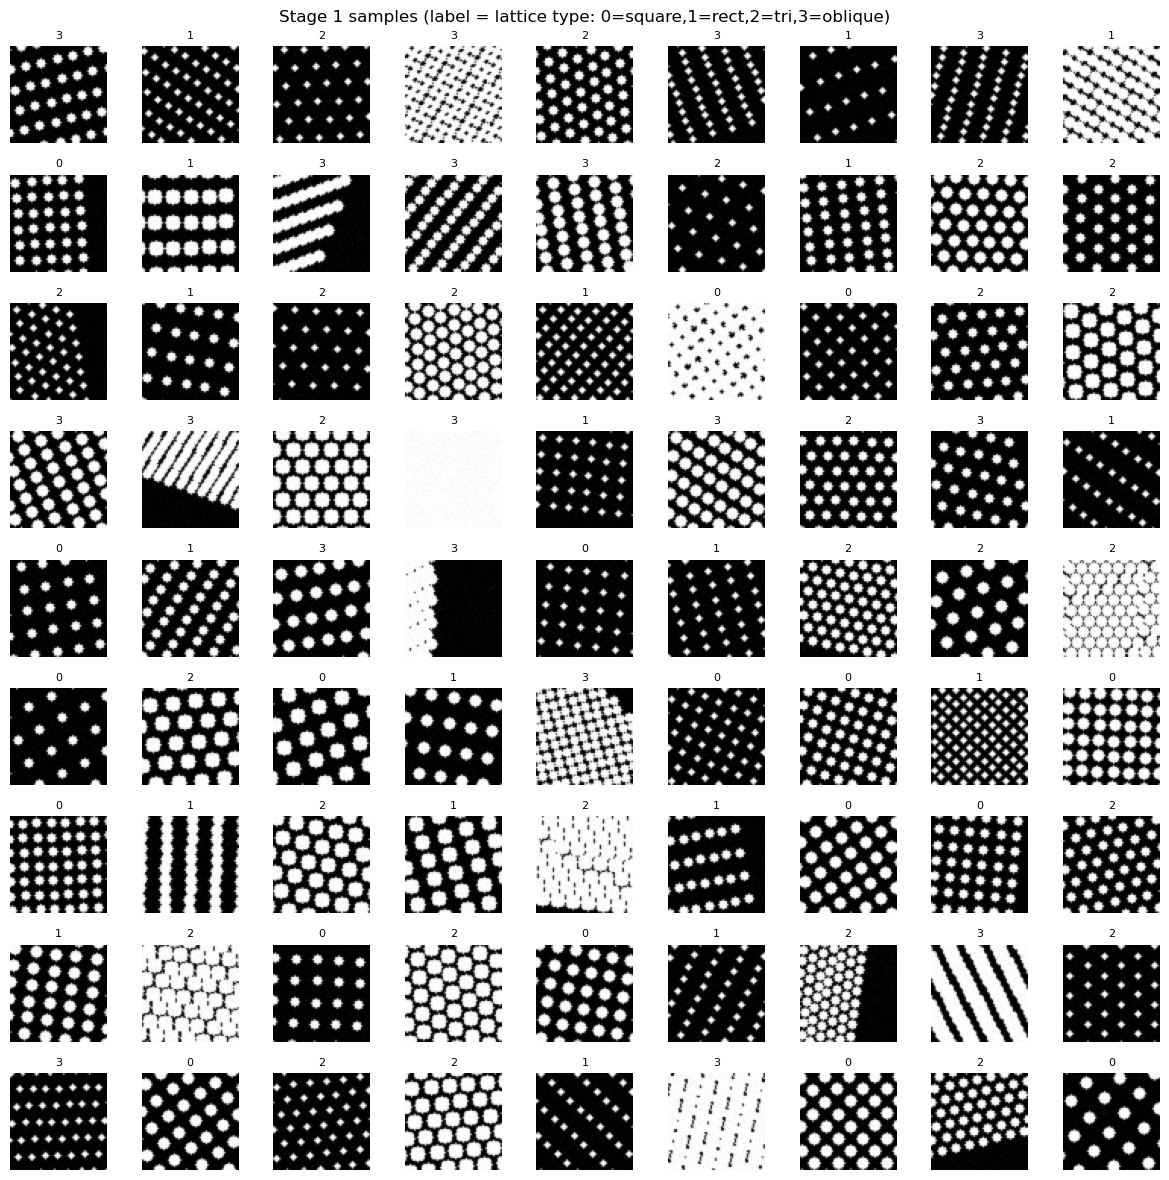

In [5]:

generate_and_save_h5(os.path.join(DATA_DIR, "stage1_synth.h5"), N_TRAIN + N_VAL, seed=1234)

with h5py.File(DATA_DIR + "/stage1_synth.h5", "r") as f:
    imgs = f["images"][:81]
    labels = f["types"][:81]

fig = plt.figure(figsize=(12,12))
for i in range(81):
    ax = plt.subplot(9,9,i+1)
    ax.imshow(imgs[i], cmap="gray", vmin=0, vmax=255)
    ax.set_title(int(labels[i]), fontsize=8)
    ax.axis("off")
plt.suptitle("Stage 1 samples (label = lattice type: 0=square,1=rect,2=tri,3=oblique)")
plt.tight_layout()
plt.show()


### tf.data pipeline for HDF5

In [6]:

def h5_dataset(path, split="train"):
    with h5py.File(path, "r") as f:
        N = f["images"].shape[0]
    n_train = N_TRAIN
    idx = np.arange(N)
    if split == "train":
        sel = idx[:n_train]
    else:
        sel = idx[n_train:n_train+N_VAL]

    def gen():
        with h5py.File(path, "r") as f:
            images = f["images"]
            ffts   = f["ffts"]
            types  = f["types"]
            params = f["params"]
            for i in sel:
                img = images[i].astype(np.float32) / 255.0
                fftm = ffts[i].astype(np.float32) / 255.0
                x = np.stack([img, fftm], axis=-1)
                y_type = tf.one_hot(int(types[i]), depth=N_CLASSES)
                y_params = params[i].astype(np.float32)
                yield x, {"type": y_type, "params": y_params}

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 2), dtype=tf.float32),
            {
                "type":   tf.TensorSpec(shape=(N_CLASSES,), dtype=tf.float32),
                "params": tf.TensorSpec(shape=(PARAM_DIM,), dtype=tf.float32),
            },
        ),
    )
    return ds

BATCH_SIZE = 128
train_ds = h5_dataset(DATASET_PATH, "train").shuffle(4096, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = h5_dataset(DATASET_PATH, "val").batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1755078172.083133   30323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


### Model: dual-branch CNN (spatial + FFT)

In [7]:

from tensorflow.keras import layers, models, optimizers, callbacks

def conv_block(x, filters, k=3, s=1):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def branch_backbone(inp):
    x = conv_block(inp, 32)
    x = conv_block(x, 32)
    x = conv_block(x, 64, s=2)   # 32x32
    x = conv_block(x, 64)
    x = conv_block(x, 128, s=2)  # 16x16
    x = conv_block(x, 128)
    x = conv_block(x, 256, s=2)  # 8x8
    x = conv_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    return x

inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 2))
spatial = layers.Lambda(lambda t: t[..., :1])(inp)
fftmag  = layers.Lambda(lambda t: t[..., 1:])(inp)

feat_spatial = branch_backbone(spatial)
feat_fft = branch_backbone(fftmag)

h = layers.Concatenate()([feat_spatial, feat_fft])
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)

out_type = layers.Dense(N_CLASSES, activation="softmax", name="type")(h)
out_params = layers.Dense(PARAM_DIM, activation="linear", name="params")(h)

model = models.Model(inputs=inp, outputs={"type": out_type, "params": out_params})
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 64, 1) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 64, 1) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        288 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │        288 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      9,216 │ re_lu_8[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,432 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     18,432 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,515,021 (9.59 MB)

 Trainable params: 2,511,181 (9.58 MB)

 Non-trainable params: 3,840 (15.00 KB)

### Compile: multi-task losses and callbacks

In [8]:

losses = {
    "type": "categorical_crossentropy",
    "params": "mse",
}
loss_weights = {"type": 1.0, "params": 1.0}

opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics={"type": ["accuracy"], "params": ["mae"]})

ckpt_dir = os.path.join(MODELS_DIR, "ckpt_best")
os.makedirs(ckpt_dir, exist_ok=True)

cbs = [
    callbacks.ModelCheckpoint(os.path.join(ckpt_dir, "best.weights.h5"),
                              monitor="val_type_accuracy", save_best_only=True, save_weights_only=True, mode="max"),
    callbacks.EarlyStopping(monitor="val_type_accuracy", patience=8, restore_best_weights=True, mode="max"),
    callbacks.ReduceLROnPlateau(monitor="val_type_accuracy", factor=0.5, patience=4, min_lr=1e-6, mode="max"),
    callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, "tensorboard", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))),
]

EPOCHS = 25
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs)


Epoch 1/25


2025-08-13 11:43:23.912206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 917 of 4096
2025-08-13 11:43:33.916264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1872 of 4096
2025-08-13 11:43:33.916264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1872 of 4096
2025-08-13 11:43:53.914290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3733 of 4096
2025-08-13 11:43:53.914290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3733 of 4096
2025-08-13 11:43:57.713207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 11:43:57.713207: I tensorflow/c

      1/Unknown 58s 58s/step - loss: 1.8757 - params_loss: 0.4413 - params_mae: 0.5695 - type_accuracy: 0.2734 - type_loss: 1.4344

I0000 00:00:1755078248.130399   33722 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    156/Unknown 228s 1s/step - loss: 1.2749 - params_loss: 0.1756 - params_mae: 0.2911 - type_accuracy: 0.4946 - type_loss: 1.0993

2025-08-13 11:47:00.272242: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4645', 32 bytes spill stores, 32 bytes spill loads

2025-08-13 11:47:00.312036: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4643', 48 bytes spill stores, 48 bytes spill loads

2025-08-13 11:47:00.359275: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4643', 4 bytes spill stores, 4 bytes spill loads

2025-08-13 11:47:00.377934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4643', 120 bytes spill stores, 120 bytes spill loads

2025-08-13 11:47:00.525893: I external/l

    157/Unknown 234s 1s/step - loss: 1.2733 - params_loss: 0.1755 - params_mae: 0.2910 - type_accuracy: 0.4954 - type_loss: 1.0978

2025-08-13 11:47:03.817603: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-13 11:47:03.817643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 11:47:03.817646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 11:47:03.817651: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
/home/renlephy/.local/share/mamba/envs/msl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat

157/157 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - loss: 1.0169 - params_loss: 0.1589 - params_mae: 0.2686 - type_accuracy: 0.6206 - type_loss: 0.8559 - val_loss: 2.0624 - val_params_loss: 0.1960 - val_params_mae: 0.3158 - val_type_accuracy: 0.2560 - val_type_loss: 1.8658 - learning_rate: 3.0000e-04
Epoch 2/25
Epoch 2/25


2025-08-13 11:47:27.319193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-08-13 11:47:37.521093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 959 of 4096
2025-08-13 11:47:37.521093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 959 of 4096
2025-08-13 11:47:47.523049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1926 of 4096
2025-08-13 11:47:47.523049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1926 of 4096
2025-08-13 11:47:57.525804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling

157/157 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - loss: 0.6459 - params_loss: 0.1493 - params_mae: 0.2536 - type_accuracy: 0.7898 - type_loss: 0.4968 - val_loss: 1.8066 - val_params_loss: 0.1653 - val_params_mae: 0.2862 - val_type_accuracy: 0.2565 - val_type_loss: 1.6410 - learning_rate: 3.0000e-04
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - loss: 0.6459 - params_loss: 0.1493 - params_mae: 0.2536 - type_accuracy: 0.7898 - type_loss: 0.4968 - val_loss: 1.8066 - val_params_loss: 0.1653 - val_params_mae: 0.2862 - val_type_accuracy: 0.2565 - val_type_loss: 1.6410 - learning_rate: 3.0000e-04
Epoch 3/25


2025-08-13 11:51:24.415013: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-13 11:51:24.415047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 11:51:24.415050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 11:51:24.415064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 11:51:34.594612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 974 of 4096
2025-08-13 11:51:34.594612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 974 of 4096
2025-0

157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.5521 - params_loss: 0.1467 - params_mae: 0.2495 - type_accuracy: 0.8291 - type_loss: 0.4062 - val_loss: 2.8178 - val_params_loss: 0.1690 - val_params_mae: 0.2855 - val_type_accuracy: 0.2685 - val_type_loss: 2.6524 - learning_rate: 3.0000e-04
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.5521 - params_loss: 0.1467 - params_mae: 0.2495 - type_accuracy: 0.8291 - type_loss: 0.4062 - val_loss: 2.8178 - val_params_loss: 0.1690 - val_params_mae: 0.2855 - val_type_accuracy: 0.2685 - val_type_loss: 2.6524 - learning_rate: 3.0000e-04
Epoch 4/25


2025-08-13 11:55:22.835929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 11:55:22.835955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 11:55:22.835971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 11:55:33.007936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 972 of 4096
2025-08-13 11:55:33.007936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 972 of 4096
2025-08-13 11:55:43.015649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1940 of 4096
2025-08-13 11:55:43.015649: I tensorflow/core

157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.4479 - params_loss: 0.1448 - params_mae: 0.2471 - type_accuracy: 0.8765 - type_loss: 0.3031 - val_loss: 0.7358 - val_params_loss: 0.1583 - val_params_mae: 0.2764 - val_type_accuracy: 0.7940 - val_type_loss: 0.5794 - learning_rate: 3.0000e-04
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.4479 - params_loss: 0.1448 - params_mae: 0.2471 - type_accuracy: 0.8765 - type_loss: 0.3031 - val_loss: 0.7358 - val_params_loss: 0.1583 - val_params_mae: 0.2764 - val_type_accuracy: 0.7940 - val_type_loss: 0.5794 - learning_rate: 3.0000e-04
Epoch 5/25


2025-08-13 11:59:19.185813: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-13 11:59:19.185881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 11:59:19.185885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 11:59:19.185900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 11:59:29.370310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 965 of 4096
2025-08-13 11:59:29.370310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 965 of 4096
2025-0

157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.3539 - params_loss: 0.1435 - params_mae: 0.2468 - type_accuracy: 0.9159 - type_loss: 0.2107 - val_loss: 1.1199 - val_params_loss: 0.1557 - val_params_mae: 0.2665 - val_type_accuracy: 0.7370 - val_type_loss: 0.9673 - learning_rate: 3.0000e-04
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.3539 - params_loss: 0.1435 - params_mae: 0.2468 - type_accuracy: 0.9159 - type_loss: 0.2107 - val_loss: 1.1199 - val_params_loss: 0.1557 - val_params_mae: 0.2665 - val_type_accuracy: 0.7370 - val_type_loss: 0.9673 - learning_rate: 3.0000e-04
Epoch 6/25


2025-08-13 12:03:25.644479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 969 of 4096
2025-08-13 12:03:45.647615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2878 of 4096
2025-08-13 12:03:45.647615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2878 of 4096
2025-08-13 12:03:58.238776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:03:58.238776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.2823 - params_loss: 0.1409 - params_mae: 0.2428 - type_accuracy: 0.9456 - type_loss: 0.1413 - val_loss: 2.7976 - val_params_loss: 0.1730 - val_params_mae: 0.2946 - val_type_accuracy: 0.4560 - val_type_loss: 2.6291 - learning_rate: 3.0000e-04
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.2823 - params_loss: 0.1409 - params_mae: 0.2428 - type_accuracy: 0.9456 - type_loss: 0.1413 - val_loss: 2.7976 - val_params_loss: 0.1730 - val_params_mae: 0.2946 - val_type_accuracy: 0.4560 - val_type_loss: 2.6291 - learning_rate: 3.0000e-04
Epoch 7/25


2025-08-13 12:07:23.152863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 962 of 4096
2025-08-13 12:07:33.153222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1921 of 4096
2025-08-13 12:07:33.153222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1921 of 4096
2025-08-13 12:07:43.157568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2867 of 4096
2025-08-13 12:07:43.157568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2867 of 4096
2025-08-13 12:07:56.164517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:07:56.164517: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - loss: 0.2400 - params_loss: 0.1392 - params_mae: 0.2404 - type_accuracy: 0.9631 - type_loss: 0.1005 - val_loss: 1.1810 - val_params_loss: 0.1597 - val_params_mae: 0.2674 - val_type_accuracy: 0.7295 - val_type_loss: 1.0319 - learning_rate: 3.0000e-04
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - loss: 0.2400 - params_loss: 0.1392 - params_mae: 0.2404 - type_accuracy: 0.9631 - type_loss: 0.1005 - val_loss: 1.1810 - val_params_loss: 0.1597 - val_params_mae: 0.2674 - val_type_accuracy: 0.7295 - val_type_loss: 1.0319 - learning_rate: 3.0000e-04
Epoch 8/25


2025-08-13 12:11:18.597578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 961 of 4096
2025-08-13 12:11:38.592658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2750 of 4096
2025-08-13 12:11:38.592658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2750 of 4096
2025-08-13 12:11:48.597039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3705 of 4096
2025-08-13 12:11:48.597039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3705 of 4096
2025-08-13 12:11:52.702622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:11:52.702622: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1963 - params_loss: 0.1368 - params_mae: 0.2378 - type_accuracy: 0.9786 - type_loss: 0.0595 - val_loss: 1.0257 - val_params_loss: 0.1460 - val_params_mae: 0.2496 - val_type_accuracy: 0.8090 - val_type_loss: 0.8861 - learning_rate: 3.0000e-04
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1963 - params_loss: 0.1368 - params_mae: 0.2378 - type_accuracy: 0.9786 - type_loss: 0.0595 - val_loss: 1.0257 - val_params_loss: 0.1460 - val_params_mae: 0.2496 - val_type_accuracy: 0.8090 - val_type_loss: 0.8861 - learning_rate: 3.0000e-04
Epoch 9/25


2025-08-13 12:15:07.926982: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-13 12:15:07.927014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 12:15:07.927017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 12:15:07.927032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 12:15:18.114234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 962 of 4096
2025-08-13 12:15:18.114234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 962 of 4096
2025-0

157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.1813 - params_loss: 0.1346 - params_mae: 0.2355 - type_accuracy: 0.9837 - type_loss: 0.0473 - val_loss: 1.2038 - val_params_loss: 0.1497 - val_params_mae: 0.2515 - val_type_accuracy: 0.7950 - val_type_loss: 1.0597 - learning_rate: 3.0000e-04
Epoch 10/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.1813 - params_loss: 0.1346 - params_mae: 0.2355 - type_accuracy: 0.9837 - type_loss: 0.0473 - val_loss: 1.2038 - val_params_loss: 0.1497 - val_params_mae: 0.2515 - val_type_accuracy: 0.7950 - val_type_loss: 1.0597 - learning_rate: 3.0000e-04
Epoch 10/25


2025-08-13 12:19:15.655836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 936 of 4096
2025-08-13 12:19:25.656225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1892 of 4096
2025-08-13 12:19:25.656225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1892 of 4096
2025-08-13 12:19:45.661266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3788 of 4096
2025-08-13 12:19:45.661266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3788 of 4096
2025-08-13 12:19:48.832441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:19:48.832441: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.1934 - params_loss: 0.1334 - params_mae: 0.2342 - type_accuracy: 0.9787 - type_loss: 0.0601 - val_loss: 1.6619 - val_params_loss: 0.1568 - val_params_mae: 0.2580 - val_type_accuracy: 0.6240 - val_type_loss: 1.5188 - learning_rate: 3.0000e-04
Epoch 11/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.1934 - params_loss: 0.1334 - params_mae: 0.2342 - type_accuracy: 0.9787 - type_loss: 0.0601 - val_loss: 1.6619 - val_params_loss: 0.1568 - val_params_mae: 0.2580 - val_type_accuracy: 0.6240 - val_type_loss: 1.5188 - learning_rate: 3.0000e-04
Epoch 11/25


2025-08-13 12:23:02.115936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 12:23:02.115972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 12:23:02.115989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 12:23:12.144574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 963 of 4096
2025-08-13 12:23:12.144574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 963 of 4096
2025-08-13 12:23:22.148519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1902 of 4096
2025-08-13 12:23:22.148519: I tensorflow/core

157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.1744 - params_loss: 0.1305 - params_mae: 0.2311 - type_accuracy: 0.9841 - type_loss: 0.0442 - val_loss: 1.1905 - val_params_loss: 0.1562 - val_params_mae: 0.2536 - val_type_accuracy: 0.7400 - val_type_loss: 1.0425 - learning_rate: 3.0000e-04
Epoch 12/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.1744 - params_loss: 0.1305 - params_mae: 0.2311 - type_accuracy: 0.9841 - type_loss: 0.0442 - val_loss: 1.1905 - val_params_loss: 0.1562 - val_params_mae: 0.2536 - val_type_accuracy: 0.7400 - val_type_loss: 1.0425 - learning_rate: 3.0000e-04
Epoch 12/25


2025-08-13 12:26:58.214434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1234263584705461227
2025-08-13 12:26:58.214472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4860554776866305423
2025-08-13 12:26:58.214491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7381718458242727934
2025-08-13 12:27:08.243152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 966 of 4096
2025-08-13 12:27:08.243152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 966 of 4096
2025-08-13 12:27:18.247580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1916 of 4096
2025-08-13 12:27:18.247580: I tensorflow/core

157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1829 - params_loss: 0.1280 - params_mae: 0.2295 - type_accuracy: 0.9797 - type_loss: 0.0554 - val_loss: 1.1864 - val_params_loss: 0.1750 - val_params_mae: 0.2645 - val_type_accuracy: 0.7770 - val_type_loss: 1.0287 - learning_rate: 3.0000e-04
Epoch 13/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1829 - params_loss: 0.1280 - params_mae: 0.2295 - type_accuracy: 0.9797 - type_loss: 0.0554 - val_loss: 1.1864 - val_params_loss: 0.1750 - val_params_mae: 0.2645 - val_type_accuracy: 0.7770 - val_type_loss: 1.0287 - learning_rate: 3.0000e-04
Epoch 13/25


2025-08-13 12:31:08.553308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 958 of 4096
2025-08-13 12:31:28.548012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2838 of 4096
2025-08-13 12:31:28.548012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2838 of 4096
2025-08-13 12:31:38.550646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3789 of 4096
2025-08-13 12:31:38.550646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3789 of 4096
2025-08-13 12:31:41.824179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:31:41.824179: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1380 - params_loss: 0.1188 - params_mae: 0.2191 - type_accuracy: 0.9933 - type_loss: 0.0191 - val_loss: 0.9144 - val_params_loss: 0.1549 - val_params_mae: 0.2460 - val_type_accuracy: 0.8050 - val_type_loss: 0.7669 - learning_rate: 1.5000e-04
Epoch 14/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1380 - params_loss: 0.1188 - params_mae: 0.2191 - type_accuracy: 0.9933 - type_loss: 0.0191 - val_loss: 0.9144 - val_params_loss: 0.1549 - val_params_mae: 0.2460 - val_type_accuracy: 0.8050 - val_type_loss: 0.7669 - learning_rate: 1.5000e-04
Epoch 14/25


2025-08-13 12:35:08.429480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 938 of 4096
2025-08-13 12:35:18.436118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1887 of 4096
2025-08-13 12:35:18.436118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1887 of 4096
2025-08-13 12:35:28.437683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2830 of 4096
2025-08-13 12:35:28.437683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2830 of 4096
2025-08-13 12:35:41.932642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:35:41.932642: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1194 - params_loss: 0.1104 - params_mae: 0.2107 - type_accuracy: 0.9969 - type_loss: 0.0090 - val_loss: 0.9232 - val_params_loss: 0.1599 - val_params_mae: 0.2470 - val_type_accuracy: 0.8120 - val_type_loss: 0.7705 - learning_rate: 1.5000e-04
Epoch 15/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 0.1194 - params_loss: 0.1104 - params_mae: 0.2107 - type_accuracy: 0.9969 - type_loss: 0.0090 - val_loss: 0.9232 - val_params_loss: 0.1599 - val_params_mae: 0.2470 - val_type_accuracy: 0.8120 - val_type_loss: 0.7705 - learning_rate: 1.5000e-04
Epoch 15/25


2025-08-13 12:39:07.961515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 959 of 4096
2025-08-13 12:39:27.956089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2846 of 4096
2025-08-13 12:39:27.956089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2846 of 4096
2025-08-13 12:39:37.960570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3811 of 4096
2025-08-13 12:39:37.960570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3811 of 4096
2025-08-13 12:39:40.938991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:39:40.938991: I tensorflow/c

157/157 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - loss: 0.1092 - params_loss: 0.1014 - params_mae: 0.2029 - type_accuracy: 0.9970 - type_loss: 0.0078 - val_loss: 1.0035 - val_params_loss: 0.1895 - val_params_mae: 0.2583 - val_type_accuracy: 0.8275 - val_type_loss: 0.8220 - learning_rate: 1.5000e-04
Epoch 16/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - loss: 0.1092 - params_loss: 0.1014 - params_mae: 0.2029 - type_accuracy: 0.9970 - type_loss: 0.0078 - val_loss: 1.0035 - val_params_loss: 0.1895 - val_params_mae: 0.2583 - val_type_accuracy: 0.8275 - val_type_loss: 0.8220 - learning_rate: 1.5000e-04
Epoch 16/25


2025-08-13 12:43:05.191452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 950 of 4096
2025-08-13 12:43:15.192473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1909 of 4096
2025-08-13 12:43:15.192473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1909 of 4096
2025-08-13 12:43:35.185641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3811 of 4096
2025-08-13 12:43:35.185641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3811 of 4096
2025-08-13 12:43:38.169755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-08-13 12:43:38.169755: I tensorflow/c

106/157 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - loss: 0.1012 - params_loss: 0.0947 - params_mae: 0.1969 - type_accuracy: 0.9976 - type_loss: 0.0065

KeyboardInterrupt: 

### Evaluation: numerical metrics and qualitative reconstructions

In [ ]:

def angle_from_sin_cos(s, c):
    return np.arctan2(s, c)

def reconstruct_from_params(params_vec, lattice_type):
    a_hat, b_hat, r_hat, sin_g, cos_g, sin_t, cos_t, x0_hat, y0_hat = params_vec
    a_px = float(a_hat * IMG_SIZE)
    b_px = float(b_hat * IMG_SIZE)
    r_px = float(np.clip(r_hat, 0.5/IMG_SIZE, 0.5) * IMG_SIZE)
    gamma = float(angle_from_sin_cos(sin_g, cos_g))
    theta = float(angle_from_sin_cos(sin_t, cos_t))
    img = render_lattice_image(IMG_SIZE, IMG_SIZE, int(lattice_type), a_px, b_px, gamma, theta, x0_hat, y0_hat, r_px,
                               blur_sigma=BLUR_SIGMA, noise_std=0.0)
    return img

def evaluate_and_visualize(model, n_vis=6):
    with h5py.File(DATASET_PATH, "r") as f:
        sel = np.arange(N_TRAIN, N_TRAIN+N_VAL)
        idx = np.random.choice(sel, size=n_vis, replace=False)

        imgs = f["images"][idx].astype(np.float32)/255.0
        ffts = f["ffts"][idx].astype(np.float32)/255.0
        types = f["types"][idx].astype(np.int32)
        params_true = f["params"][idx].astype(np.float32)

    x_in = np.stack([imgs, ffts], axis=-1)
    preds = model.predict(x_in, verbose=0)
    type_pred = np.argmax(preds["type"], axis=-1)
    params_pred = preds["params"]

    def ang_err_deg(s_true, c_true, s_pred, c_pred):
        a_true = np.arctan2(s_true, c_true)
        a_pred = np.arctan2(s_pred, c_pred)
        d = np.rad2deg(np.angle(np.exp(1j*(a_pred - a_true))))
        return np.abs(d)

    gamma_err = ang_err_deg(params_true[:,3], params_true[:,4], params_pred[:,3], params_pred[:,4]).mean()
    theta_err = ang_err_deg(params_true[:,5], params_true[:,6], params_pred[:,5], params_pred[:,6]).mean()
    mae_lengths = np.mean(np.abs(params_true[:, :3] - params_pred[:, :3]), axis=0)
    mae_offsets = np.mean(np.abs(params_true[:, 7:] - params_pred[:, 7:]), axis=0)
    acc = np.mean(type_pred == types)

    print(f"Validation sample accuracy (coarse): {acc:.3f}")
    print(f"MAE lengths [a_hat, b_hat, r_hat]: {mae_lengths}")
    print(f"MAE offsets [x0_hat, y0_hat]: {mae_offsets}")
    print(f"Angle RMSE-ish | gamma: {gamma_err:.2f} deg, theta: {theta_err:.2f} deg")

    n = n_vis
    fig = plt.figure(figsize=(9, 4*n))
    for i in range(n):
        gt_img = imgs[i]
        pred_img = reconstruct_from_params(params_pred[i], type_pred[i])
        gt_fft = image_fft_logmag(gt_img)
        pred_fft = image_fft_logmag(pred_img)

        ax = plt.subplot(n, 4, 4*i+1); ax.imshow(gt_img, cmap="gray"); ax.set_title(f"GT img | type={types[i]}"); ax.axis("off")
        ax = plt.subplot(n, 4, 4*i+2); ax.imshow(pred_img, cmap="gray"); ax.set_title(f"Pred img | type={type_pred[i]}"); ax.axis("off")
        ax = plt.subplot(n, 4, 4*i+3); ax.imshow(gt_fft, cmap="gray"); ax.set_title("GT FFT"); ax.axis("off")
        ax = plt.subplot(n, 4, 4*i+4); ax.imshow(pred_fft, cmap="gray"); ax.set_title("Pred FFT"); ax.axis("off")

    plt.tight_layout()
    plt.show()

evaluate_and_visualize(model, n_vis=6)


### Save model

In [ ]:

saved_path = os.path.join(MODELS_DIR, "saved_model")
model.save(saved_path, include_optimizer=False)
print(f"Saved model to: {saved_path}")
